In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if __name__ == '__main__':
    env = gym.make('Blackjack-v0')
    EPS = 0.05
    GAMMA = 1.0


In [3]:
#Spaces in the environment
agentSumSpace = [i for i in range(4, 22)] #Anything over 22 is irrelevant 22+ is a fail state
dealerShowCardSpace = [i+1 for i in range(10)]#Dealer has a card showing
agentAceSpace = [False, True]
actionSpace = [0, 1] # stay or hit
stateSpace = []

In [4]:
Q = {}
C = {} #sum of relative weights
for total in agentSumSpace:
    for card in dealerShowCardSpace:
        for ace in agentAceSpace:
            for action in actionSpace:
                Q[((total, card, ace), action)] = 0
                C[((total, card, ace), action)] = 0
            stateSpace.append((total, card, ace))

In [5]:
targetPolicy = {} #calculate optimal behaviour in environment
for state in stateSpace:
    values = np.array([Q[(state, a)] for a in actionSpace ])
    best = np.random.choice(np.where(values==values.max())[0])        
    targetPolicy[state] = actionSpace[best]


In [6]:
numEpisodes = 1000000 #play million games to train
for i in range(numEpisodes):        
    memory = []
    if i % 100000 == 0:
        print('starting episode', i)
    behaviorPolicy = {}
    for state in stateSpace:
        rand = np.random.random()
        if rand < 1 - EPS:
            behaviorPolicy[state] = [targetPolicy[state]]
        else:
            behaviorPolicy[state] = actionSpace
    observation = env.reset()
    done = False
    while not done:
        action = np.random.choice(behaviorPolicy[observation])
        observation_, reward, done, info = env.step(action)
        memory.append((observation[0], observation[1], observation[2], action, reward))
        observation = observation_
    memory.append((observation[0], observation[1], observation[2], action, reward))    
    G = 0
    W = 1
    last = True
    for playerSum, dealerCard, usableAce, action, reward in reversed(memory):
        sa = ((playerSum, dealerCard, usableAce), action)
        if last:
            last = False
        else:
            C[sa] += W
            Q[sa] += (W / C[sa])*(G-Q[sa])                
            values = np.array([Q[(state, a)] for a in actionSpace ])
            best = np.random.choice(np.where(values==values.max())[0])        
            targetPolicy[state] = actionSpace[best]
            if action != targetPolicy[state]:
                        break
            if len(behaviorPolicy[state]) == 1:
                        prob = 1 - EPS
            else:
                prob = EPS / len(behaviorPolicy[state])             
            W *= 1/prob                             
        G = GAMMA*G + reward
    if EPS - 1e-7 > 0:
        EPS -= 1e-7
    else:
        EPS = 0

starting episode 0
starting episode 100000
starting episode 200000
starting episode 300000
starting episode 400000
starting episode 500000
starting episode 600000
starting episode 700000
starting episode 800000
starting episode 900000


In [11]:
numEpisodes = 1000 # play 1000 games to test
rewards = np.zeros(numEpisodes)
totalReward = 0
wins = 0
losses = 0
draws = 0
print('getting ready to test')   
for i in range(numEpisodes):
    observation = env.reset()
    done = False
    while not done:
        action = targetPolicy[observation]
        observation_, reward, done, info = env.step(action)            
        observation = observation_
    totalReward += reward
    rewards[i] = totalReward

    if reward >= 1:
        wins += 1
    elif reward == 0:
        draws += 1
    elif reward == -1:
        losses += 1

getting ready to test


win rate 0.268 loss rate 0.692 draw rate 0.04


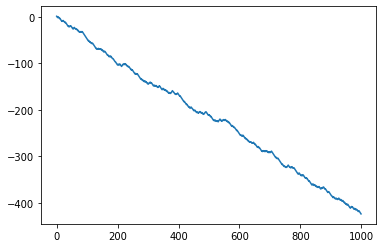

In [10]:
#Show the results
wins /= numEpisodes
losses /= numEpisodes
draws /= numEpisodes
print('win rate', wins, 'loss rate', losses, 'draw rate', draws) # not great
plt.plot(rewards)
plt.show()